
# Predicting Air Pollution Levels using Random Forest

This notebook demonstrates the steps to use a Random Forest model to predict air pollution levels.


In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor


## Load Data

Load your training and testing data from CSV files.


In [2]:
# set random seed
np.random.seed(42)

df_test = pd.read_csv('prepped_data/test_data.csv')
df_train = pd.read_csv('prepped_data/train_data.csv')

In [3]:
# check date range of the data
df_train['date'].min(), df_train['date'].max(), df_test['date'].min(), df_test['date'].max()

('2021-05-06', '2022-04-29', '2022-05-03', '2022-08-05')

In [4]:
# Define a function to reposition and rename columns
def reposition_and_rename_columns(df):
    # Get the column names
    columns = df.columns.tolist()

    # Remove the 'Hour' and 'Sum_Volume' columns from the list
    columns.remove('Hour')
    columns.remove('Sum_Volume')

    # Insert 'hour' column at the 8th position
    columns.insert(11, 'Hour')

    # Insert 'traffic_volume_sum' column at the 9th position
    columns.insert(12, 'Sum_Volume')

    # Reorder the DataFrame with the new column order
    df = df[columns]  # Reordering columns without reindexing

    # Rename columns
    df = df.rename(columns={'Hour': 'hour', 'Sum_Volume': 'traffic_volume_sum'})

    return df

# Reposition and rename columns for df_train
df_train = reposition_and_rename_columns(df_train)

# Reposition and rename columns for df_test
df_test = reposition_and_rename_columns(df_test)

In [5]:
df_train

,date,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PM25_ugm3,SiteID,Lat,Long,...,DCC-AQ5-pm4,DCC-AQ52-pm4,DCC-AQ6-pm4,DCC-AQ1-so2,DCC-AQ13-so2,DCC-AQ22-so2,TNO2161-tsp,TNO2162-tsp,TNO4435-tsp,TNT1088-tsp
0,2021-05-06,-16.485096,4.267365,70.815263,0.275750,786.544417,3.815981,325,53.327618,-6.309232,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.9,8.78
1,2021-05-06,-0.466100,11.630600,71.484000,0.282222,800.609500,7.049500,770,53.335275,-6.317469,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
2,2021-05-06,32.199310,14.004828,61.570000,0.404724,795.937567,3.140167,619,53.326383,-6.322198,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
3,2021-05-06,24.686167,31.937167,54.446000,0.567000,830.621600,9.055143,487,53.329272,-6.334426,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.2,4.30
4,2021-05-06,0.391708,-6.196404,80.784941,0.293809,790.788080,3.640216,547,53.306713,-6.301091,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.9,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,2022-04-29,54.393625,22.326125,58.886000,0.763000,NaN,16.530875,45,53.348265,-6.308470,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34919,2022-04-29,8.136800,3.548273,74.203750,0.305200,792.278818,17.119000,717,53.341981,-6.316828,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34920,2022-04-29,40.311571,17.494600,57.480000,0.297167,777.945143,19.670143,412,53.342280,-6.346188,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50
34921,2022-04-29,16.123478,16.651783,66.063333,0.306870,772.755333,17.682042,651,53.342196,-6.328940,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,NaN,6.50


Mean Imputation
---

In [59]:
# Option to keep column names

from sklearn.impute import SimpleImputer

# Save the column names
column_names = df_train.columns

# Split train into X and Y
Xtrain = df_train.iloc[:, 7:].copy()  # Retain the column names by using copy
ytrain = df_train["PM25_ugm3"].values

# Split test into X and Y
Xtest = df_test.iloc[:, 7:].copy()  # Retain the column names by using copy
ytest = df_test["PM25_ugm3"].values

# Running a simple imputer and scaler
imputer = SimpleImputer(strategy="mean")
Xtrain_mean_imputed = pd.DataFrame(imputer.fit_transform(Xtrain), columns=Xtrain.columns)  # Assigning column names back
Xtest_mean_imputed = pd.DataFrame(imputer.transform(Xtest), columns=Xtest.columns)  # Assigning column names back

# no need to scale for random forest
# scaler = StandardScaler()
# Xtrain_scaled = pd.DataFrame(scaler.fit_transform(Xtrain_imputed), columns=Xtrain_imputed.columns)  # Assigning column names back
# Xtest_scaled = pd.DataFrame(scaler.transform(Xtest_imputed), columns=Xtest_imputed.columns)  # Assigning column names back

KNN Imputation
---

In [8]:
# Option to keep column names
from sklearn.impute import KNNImputer

# set random seed
np.random.seed(42)

# Split train into X and Y
Xtrain_KNN = df_train.iloc[:, 7:].copy()  # Retain the column names by using copy

# Split test into X and Y
Xtest_KNN = df_test.iloc[:, 7:].copy()  # Retain the column names by using copy

# Perform KNN imputation on the train and test data
imputer = KNNImputer(n_neighbors=5)
Xtrain_KNN_imputed = pd.DataFrame(imputer.fit_transform(Xtrain_KNN), columns=Xtrain_KNN.columns)  # Assigning column names back
Xtest_KNN_imputed = pd.DataFrame(imputer.transform(Xtest_KNN), columns=Xtest_KNN.columns)  # Assigning column names back

# Scale the data (not needed for random forest)
# Xtrain_KNN_scaled = pd.DataFrame(scaler.fit_transform(Xtrain_KNN_imputed), columns=Xtrain_KNN_imputed.columns)  # Assigning column names back
# Xtest_KNN_scaled = pd.DataFrame(scaler.transform(Xtest_KNN_imputed), columns=Xtest_KNN_imputed.columns)  # Assigning column names back

In [9]:
Xtrain_KNN_imputed

,SiteID,Lat,Long,day_of_week,hour,traffic_volume_sum,avgtempC,maxtempC,mintempC,sunHour,...,DCC-AQ5-pm4,DCC-AQ52-pm4,DCC-AQ6-pm4,DCC-AQ1-so2,DCC-AQ13-so2,DCC-AQ22-so2,TNO2161-tsp,TNO2162-tsp,TNO4435-tsp,TNT1088-tsp
0,325.0,53.327618,-6.309232,3.0,14.0,0.0,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900,8.78
1,770.0,53.335275,-6.317469,3.0,13.0,643.6,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
2,619.0,53.326383,-6.322198,3.0,13.0,323.6,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
3,487.0,53.329272,-6.334426,3.0,13.0,1910.0,6.0,9.0,1.0,12.0,...,3.75,3.36,5.10,2.07,-0.49,0.64,0.20,7.27,11.200,4.30
4,547.0,53.306713,-6.301091,3.0,14.0,896.4,6.0,9.0,1.0,12.0,...,3.49,3.89,6.13,2.22,-0.40,0.51,0.18,7.07,8.900,8.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,45.0,53.348265,-6.308470,4.0,10.0,1451.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,19.510,6.50
34919,717.0,53.341981,-6.316828,4.0,10.0,748.4,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.594,6.50
34920,412.0,53.342280,-6.346188,4.0,10.0,0.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.080,6.50
34921,651.0,53.342196,-6.328940,4.0,10.0,855.0,9.0,12.0,6.0,12.0,...,17.83,18.68,18.12,-0.54,-0.76,2.56,2.15,18.79,27.572,6.50


In [ ]:
# save with column names

# Xtrain_KNN_imputed.to_csv('prepped_data/with_column_names/Xtrain_KNN.csv', index=False)
# Xtrain_KNN_imputed.to_csv('prepped_data/with_column_names/Xtest_KNN.csv', index=False)
# ytrain.to_csv('prepped_data/with_column_names/ytrain.csv', index=False)
# ytest.to_csv('prepped_data/with_column_names/ytest.csv', index=False)

Transform target variable
---
Since the target variable is left-skewed (see ECA), we will apply a log transformation to make it more normally distributed. 

In [10]:
# Apply log transformation to the target variable
y_train_log = np.log1p(ytrain)
y_test_log = np.log1p(ytest)

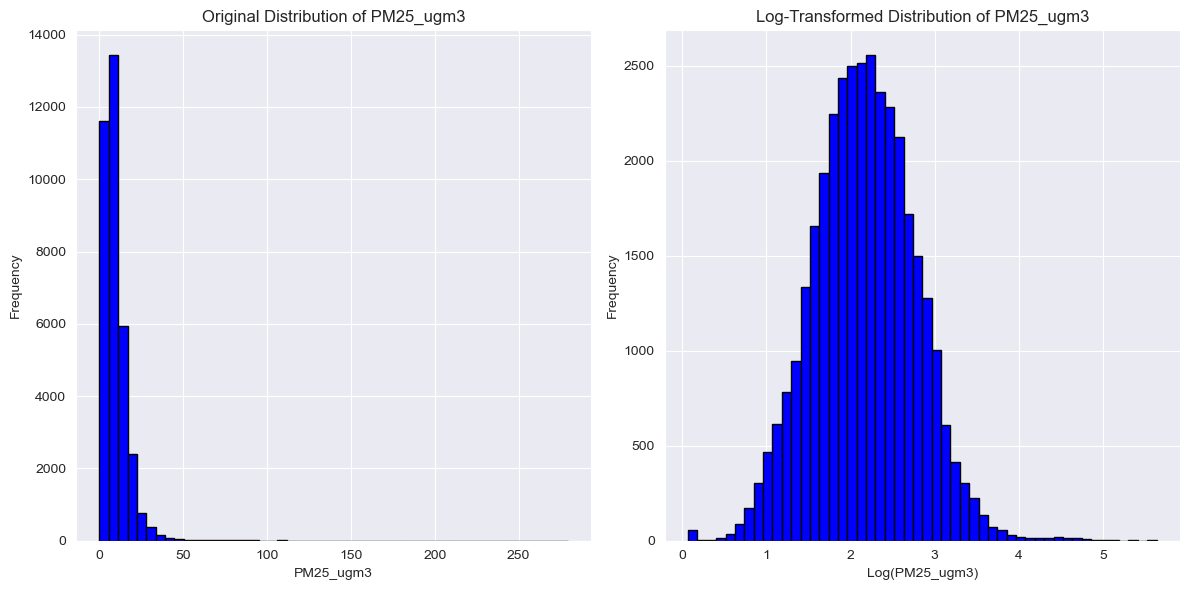

In [11]:
# plot the distribution of the target variable
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ytrain, bins=50, color='blue', edgecolor='black')
plt.title('Original Distribution of PM25_ugm3')
plt.xlabel('PM25_ugm3')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_train_log, bins=50, color='blue', edgecolor='black')
plt.title('Log-Transformed Distribution of PM25_ugm3')
plt.xlabel('Log(PM25_ugm3)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Train the Random Forest Model

Here we will configure and train our Random Forest model.


In [10]:
# shapes of the data
Xtrain_KNN_imputed.shape, y_train_log.shape, Xtest_KNN_imputed.shape, y_test_log.shape

((34923, 85), (34923,), (8272, 85), (8272,))

`TimeSeriesSplit` is used to split the training data into multiple training and validation sets. Then, a Random Forest Regressor is trained and evaluated on each split. Finally, the RMSE scores of each fold are printed along with the mean RMSE score across all folds.

In [65]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# Reset index of Xtrain_KNN_imputed
Xtrain_KNN_imputed.reset_index(drop=True, inplace=True)

# Define the number of splits (e.g., 5 splits)
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = []
for train_index, test_index in tscv.split(Xtrain_KNN_imputed):
    X_train, X_test = Xtrain_KNN_imputed.iloc[train_index], Xtrain_KNN_imputed.iloc[test_index]
    y_train, y_test = ytrain[train_index], ytrain[test_index]

    # Train the model
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_scores.append(rmse)

# Print cross-validation RMSE scores
print("Cross-Validation RMSE scores:", cv_scores)
print("Mean Cross-Validation RMSE:", np.mean(cv_scores))

Cross-Validation RMSE scores: [9.245251413776016, 9.124257497483752, 11.517070976781099, 11.4537878531756, 8.055581157931066]
Mean Cross-Validation RMSE: 9.879189779829506


## Tune Model Hyperparameters

This code performs grid search using cross-validation to find the best hyperparameters for a RandomForestRegressor model.
-  number of trees in the random forest (n_estimators)
- maximum depth of the tree (max_depth)
- minimum number of samples required to split an internal node (min_samples_split)

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 75, 100],  # Include 50 which gave better results and explore slightly more and fewer estimators
    'max_depth': [5, 10, 15, 20],   # Explore shallower and slightly deeper trees
    'max_features': ['sqrt', 'log2'],  # Continue to explore feature subset strategies
    'min_samples_leaf': [1, 2, 4],  # Explore a range that allows more generalization
    'min_samples_split': [2, 5, 10]  # Explore values around 5 which performed well
}

# Initialize RandomForestRegressor and TimeSeriesSplit
rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize and perform GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Use built-in RMSE as scoring metric
    cv=tscv,
    verbose=2,  # More detailed output during the grid search
    n_jobs=-1   # High CPU usage
)

# Fit GridSearchCV
grid_search.fit(Xtrain_KNN_imputed, y_train_log)

# Output best parameters and corresponding RMSE
print("Best parameters:", grid_search.best_params_)
print("Raw Best Score from GridSearchCV:", grid_search.best_score_)

# Calculate RMSE from the negative value
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_rmse}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Raw Best Score from GridSearchCV: -0.3923744525131191
Best RMSE: 0.6263979984906713


In [24]:
# Evaluate the model on the test set and inverse transform the predictions
best_rf_model = grid_search.best_estimator_
y_pred_log_rf = best_rf_model.predict(Xtest_KNN_imputed)
y_pred_rf = np.expm1(y_pred_log_rf)  # Use expm1 to reverse log1p transformation

# Calculate and print the test RMSE
test_rmse_rf = np.sqrt(mean_squared_error(ytest, y_pred_rf))
print(f"Random Forest Test RMSE: {test_rmse_rf}")

Random Forest Test RMSE: 5.019156983313178


In [32]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Re-evaluated parameter grid for Random Forest
param_grid_wider = {
    'n_estimators': [50, 100, 150, 200],  # Include more values
    'max_depth': [10, 15, 20, 25],        # Include broader range
    'max_features': ['sqrt', 'log2'],     # 'sqrt' and 'log2'
    'min_samples_leaf': [2, 3, 4, 5],     # Explore more around 4
    'min_samples_split': [5, 8, 10, 12]   # Include broader range
}

# Initialize RandomForestRegressor and TimeSeriesSplit
rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize and perform GridSearchCV with wider parameters
grid_search_wider = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_wider,
    scoring='neg_root_mean_squared_error',  # Use built-in RMSE as scoring metric
    cv=tscv,
    verbose=2,  # More detailed output during the grid search
    n_jobs=-1   # High CPU usage
)

# Fit GridSearchCV
grid_search_wider.fit(Xtrain_KNN_imputed, y_train_log)

# Output best parameters and corresponding RMSE
print("Best parameters:", grid_search_wider.best_params_)
print("Raw Best Score from GridSearchCV:", grid_search_wider.best_score_)

# Calculate RMSE from the negative value
best_rmse_wider = np.sqrt(-grid_search_wider.best_score_)
print(f"Best RMSE: {best_rmse_wider}")

# Evaluate the model on the test set and inverse transform the predictions
best_rf_model_wider = grid_search_wider.best_estimator_
y_pred_log_rf_wider = best_rf_model_wider.predict(Xtest_KNN_imputed)
y_pred_rf_wider = np.expm1(y_pred_log_rf_wider)  # Use expm1 to reverse log1p transformation

# Calculate and print the test RMSE
test_rmse_rf_wider = np.sqrt(mean_squared_error(ytest, y_pred_rf_wider))
print(f"Random Forest Test RMSE: {test_rmse_rf_wider}")

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Raw Best Score from GridSearchCV: -0.3908729261064122
Best RMSE: 0.6251983094238277
Random Forest Test RMSE: 5.0499871462159724


In [36]:
# Set random seed for reproducibility
np.random.seed(42)

# Refined parameter grid for Random Forest
param_grid_refined = {
    'n_estimators': [75, 100, 125],  # Focus around the best found value
    'max_depth': [10, 15, 20],       # Narrow down around the best found values
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [3, 4, 5],   # Narrow down around the best found values
    'min_samples_split': [5, 8, 10]  # Narrow down around the best found values
}

# Initialize RandomForestRegressor and TimeSeriesSplit
rf = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize and perform GridSearchCV with refined parameters
grid_search_refined = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_refined,
    scoring='neg_root_mean_squared_error',  # Use built-in RMSE as scoring metric
    cv=tscv,
    verbose=2,  # More detailed output during the grid search
    n_jobs=-1   # High CPU usage
)

# Fit GridSearchCV
grid_search_refined.fit(Xtrain_KNN_imputed, y_train_log)

# Output best parameters and corresponding RMSE
print("Best parameters:", grid_search_refined.best_params_)
print("Raw Best Score from GridSearchCV:", grid_search_refined.best_score_)

# Calculate RMSE from the negative value
best_rmse_refined = np.sqrt(-grid_search_refined.best_score_)
print(f"Best RMSE: {best_rmse_refined}")

# Evaluate the model on the test set and inverse transform the predictions
best_rf_model_refined = grid_search_refined.best_estimator_
y_pred_log_rf_refined = best_rf_model_refined.predict(Xtest_KNN_imputed)
y_pred_rf_refined = np.expm1(y_pred_log_rf_refined)  # Use expm1 to reverse log1p transformation

# Calculate and print the test RMSE
test_rmse_rf_refined = np.sqrt(mean_squared_error(ytest, y_pred_rf_refined))
print(f"Random Forest Test RMSE: {test_rmse_rf_refined}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Raw Best Score from GridSearchCV: -0.3908729261064122
Best RMSE: 0.6251983094238277
Random Forest Test RMSE: 5.0499871462159724


Key Takeaways
---
- The best parameters identified `{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}`
- An Test-RMSE of approximately 5.05 indicates that on average, the predictions of this RF-model are about 5.05 units away from the actual values


## Predict and Evaluate the Model

Now, let's make predictions on the test set and evaluate the model.


In [53]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Initialize RandomForest with best-found parameters
rf_model = RandomForestRegressor(
    max_depth=10,
    max_features='log2',
    min_samples_leaf=5,
    min_samples_split=5,
    n_estimators=100,
    random_state=42
)

# Prepare TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
training_mse_rf = []

# Training and evaluation loop for each fold
for train_index, val_index in tscv.split(Xtrain_KNN_imputed):
    X_train_fold, X_val_fold = Xtrain_mean_imputed.iloc[train_index], Xtrain_mean_imputed.iloc[val_index]
    y_train_fold, y_val_fold = y_train_log[train_index], y_train_log[val_index]

    rf_model.fit(X_train_fold, y_train_fold)
    y_train_pred = rf_model.predict(X_train_fold)

    # Inverse transform predictions
    y_train_pred_orig = np.expm1(y_train_pred)
    y_train_fold_orig = np.expm1(y_train_fold)

    # Calculate MSE on the original scale
    rmse = np.sqrt(mean_squared_error(y_train_fold_orig, y_train_pred_orig))
    training_mse_rf.append(rmse)

# Fit on entire training set
rf_model.fit(Xtrain_KNN_imputed, y_train_log)

# Predict on training and test sets
y_train_pred_full = rf_model.predict(Xtrain_KNN_imputed)
y_test_pred = rf_model.predict(Xtest_KNN_imputed)

# Inverse transform predictions
y_train_pred_full_orig = np.expm1(y_train_pred_full)
y_test_pred_orig = np.expm1(y_test_pred)

# Calculate RMSE on the original scale
train_rmse_rf = np.sqrt(mean_squared_error(np.expm1(y_train_log), y_train_pred_full_orig))
test_rmse_rf = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_test_pred_orig))

# Output the results
print("Training MSE for each fold (original scale):", training_mse_rf)
print("Training RMSE (original scale):", train_rmse_rf)
print("Test RMSE (original scale):", test_rmse_rf)

Training MSE for each fold (original scale): [6.176008087745206, 6.528434242258708, 7.133389570273079, 7.053657343255082, 6.8708983442371885]
Training RMSE (original scale): 6.752997372844557
Test RMSE (original scale): 5.049987146215973



## Feature Importance

Visualize the importance of each feature in making predictions.


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_feature_importances(model, X_train, model_name, top_n=30):
    """
    Plot feature importances for any trained model.
    Coloring of the features is based on predefined categories.
    """
    # Define categories for features
    categories = {
        'location': ['SiteID', 'Lat', 'Long'],
        'time': ['day_of_week', 'hour'],
        'traffic': ['traffic_volume_sum'],
        'climate': ['avgtempC', 'maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'humidity',
                    'winddirDegree', 'windspeedKmph', 'cloudcover', 'precipMM', 'pressure'],
        'local_AQ': ['DCC-AQ1-co', 'DCC-AQ1-no', 'DCC-AQ10-no', 'DCC-AQ13-no', 'DCC-AQ5-no', 'DCC-AQ6-no',
                     'DCC-AQ1-no2', 'DCC-AQ10-no2', 'DCC-AQ13-no2', 'DCC-AQ22-no2', 'DCC-AQ5-no2', 'DCC-AQ6-no2',
                     'DCC-AQ69-no2', 'DCC-AQ22-o3', 'DCC-AQ69-o3', 'DCC-AQ10-pm1', 'DCC-AQ13-pm1', 'DCC-AQ2-pm1',
                     'DCC-AQ3-pm1', 'DCC-AQ4-pm1', 'DCC-AQ5-pm1', 'DCC-AQ52-pm1', 'DCC-AQ6-pm1', 'TNO2161-pm1',
                     'TNO2162-pm1', 'TNO4435-pm1', 'TNT1088-pm1', 'DCC-AQ10-pm10', 'DCC-AQ13-pm10', 'DCC-AQ2-pm10',
                     'DCC-AQ22-pm10', 'DCC-AQ3-pm10', 'DCC-AQ4-pm10', 'DCC-AQ5-pm10', 'DCC-AQ52-pm10', 'DCC-AQ6-pm10',
                     'TNO2161-pm10', 'TNO2162-pm10', 'TNO4435-pm10', 'TNT1088-pm10', 'DCC-AQ10-pm2_5', 'DCC-AQ13-pm2_5',
                     'DCC-AQ2-pm2_5', 'DCC-AQ22-pm2_5', 'DCC-AQ3-pm2_5', 'DCC-AQ4-pm2_5', 'DCC-AQ5-pm2_5',
                     'DCC-AQ52-pm2_5', 'DCC-AQ6-pm2_5', 'TNO2161-pm2_5', 'TNO2162-pm2_5', 'TNO4435-pm2_5', 'TNT1088-pm2_5',
                     'DCC-AQ10-pm4', 'DCC-AQ13-pm4', 'DCC-AQ2-pm4', 'DCC-AQ3-pm4', 'DCC-AQ4-pm4', 'DCC-AQ5-pm4',
                     'DCC-AQ52-pm4', 'DCC-AQ6-pm4', 'DCC-AQ1-so2', 'DCC-AQ13-so2', 'DCC-AQ22-so2', 'TNO2161-tsp',
                     'TNO2162-tsp', 'TNO4435-tsp', 'TNT1088-tsp']
    }

    # Define colors for each category
    colors = {
        'location': 'blue',
        'time': 'orange',
        'traffic': 'purple',
        'climate': 'green',
        'local_AQ': 'red'
    }

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create a DataFrame for better visualization
    features = X_train.columns  # Ensure X_train is a DataFrame with column names
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Add category information
    def get_category(feature):
        for category, feature_list in categories.items():
            if feature in feature_list:
                return category
        return 'other'

    importance_df['Category'] = importance_df['Feature'].apply(get_category)

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    top_features = importance_df.head(top_n)
    colors_mapped = top_features['Category'].map(colors)
    
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'], top_features['Importance'], color=colors_mapped)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances from {model_name}')
    
    # Adjust layout to fit snugly
    plt.tight_layout()
    plt.ylim(-0.5, top_n - 0.5)  # Ensure the ylim fits the number of bars exactly
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

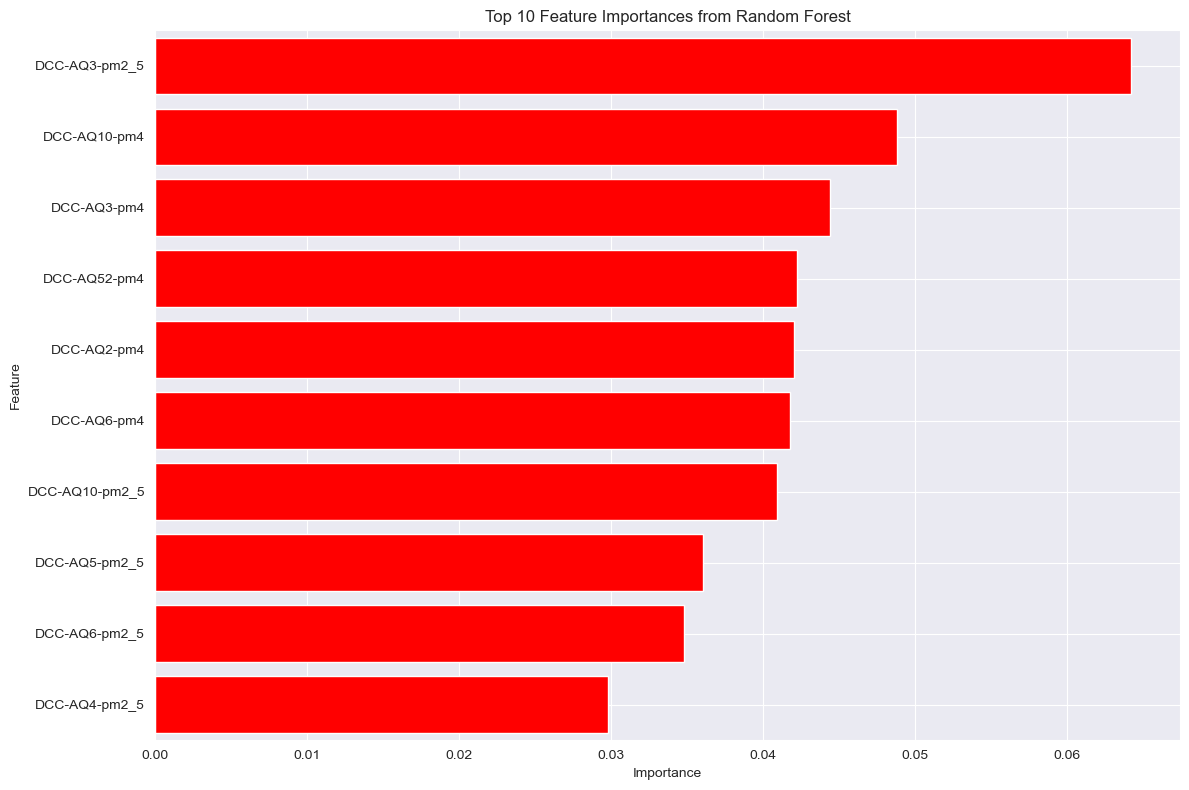

In [74]:
# Plot feature importances for the best RF model
plot_feature_importances(best_rf_model, Xtrain_KNN_imputed, model_name='Random Forest', top_n=10)

XG Boost
---

In [29]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7, 10],  # Reasonable range
    'learning_rate': [0.01, 0.05, 0.1],  # Expanded but limited range
    'n_estimators': [50, 100, 150],  # Fewer values, including some higher ones
    'colsample_bytree': [0.7, 0.8, 0.9],  # Limited range
    'subsample': [0.7, 0.8, 0.9],  # Limited range
    'reg_alpha': [0, 0.1, 0.5],  # Expanded range
    'reg_lambda': [1, 1.5, 2]  # Limited range
}


# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Grid Search CV with TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(Xtrain_KNN_imputed, y_train_log)

# Print the best parameters and best RMSE
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

# Best cross-validated model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1.5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1.5, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1.5, subsample=0.9; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators

/Users/elena/anaconda3/envs/ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0, reg_lambda=2, subsample=0.9; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, reg_alpha=0.1, reg_lambda=1, subsample=0.9; total time=   0.2s


In [39]:
# Predict on test set and inverse transform the predictions
y_pred_log_xgb = best_xgb_model.predict(Xtest_KNN_imputed)
y_pred_xgb = np.expm1(y_pred_log_xgb)  # Use expm1 to reverse log1p transformation

# Evaluate the model
test_rmse_xgb = np.sqrt(mean_squared_error(ytest, y_pred_xgb))
print(f"XGBoost Test RMSE: {test_rmse_xgb}")

XGBoost Test RMSE: 4.92570762485192


In [50]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Initialize XGBoost with best-found parameters
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=2,
    subsample=0.7,
    objective='reg:squarederror',
    random_state=42
)

# Prepare TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
training_mse = []

# Training and evaluation loop for each fold
for train_index, val_index in tscv.split(Xtrain_KNN_imputed):
    X_train_fold, X_val_fold = Xtrain_KNN_imputed.iloc[train_index], Xtrain_KNN_imputed.iloc[val_index]
    y_train_fold, y_val_fold = y_train_log[train_index], y_train_log[val_index]

    xgb_model.fit(X_train_fold, y_train_fold)
    y_train_pred = xgb_model.predict(X_train_fold)

    # Inverse transform predictions
    y_train_pred_orig = np.expm1(y_train_pred)
    y_train_fold_orig = np.expm1(y_train_fold)

    # Calculate MSE on the original scale
    rmse = np.sqrt(mean_squared_error(y_train_fold_orig, y_train_pred_orig))
    training_mse.append(rmse)

# Fit on entire training set
xgb_model.fit(Xtrain_KNN_imputed, y_train_log)

# Predict on training and test sets
y_train_pred_full = xgb_model.predict(Xtrain_KNN_imputed)
y_test_pred = xgb_model.predict(Xtest_KNN_imputed)

# Inverse transform predictions
y_train_pred_full_orig = np.expm1(y_train_pred_full)
y_test_pred_orig = np.expm1(y_test_pred)

# Calculate RMSE on the original scale
train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train_log), y_train_pred_full_orig))
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_test_pred_orig))

# Output the results
print("Training RMSE for each fold (original scale):", training_mse)
print("Training RMSE (original scale):", train_rmse)
print("Test RMSE (original scale):", test_rmse)

Training RMSE for each fold (original scale): [6.154629545901338, 6.6179820668161575, 7.236475251093455, 7.22871724131285, 7.104228737178762]
Training RMSE (original scale): 6.959100436666779
Test RMSE (original scale): 4.92570762485192


Feature Importances for XGBoost Model

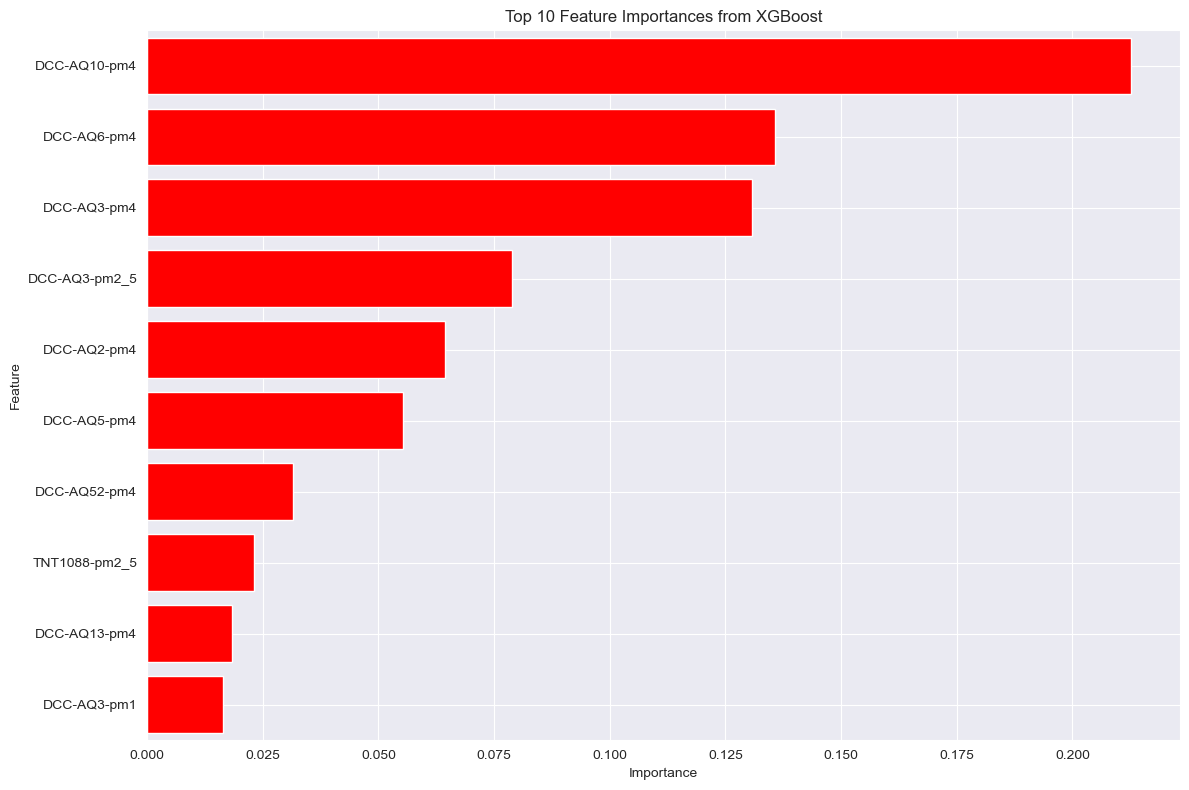

In [73]:
# Plot feature importances for the best XGBoost model
plot_feature_importances(best_xgb_model, Xtrain_KNN_imputed, model_name='XGBoost', top_n=10)